# Лабораторная работа № 2
## Линейная нейронная сеть. Правило обучения Уидроу-Хоффа

`Цель работы:` исследование свойств линейной нейронной сети и алгоритмов ее обучения, применение сети в задачах аппроксимации и фильтрации

|Студент| Мариничев И.А.|
|-|-|
|**Группа**| **М8О-408Б-19**|
|**Вариант**| **5**|

Импортируем нужные библиотеки

In [1]:
import numpy as np

import torch
import torch.nn as nn

from tqdm import tqdm

import matplotlib.pyplot as plt

Определим входные данные для задачи аппроксимации функции

In [2]:
D = 5  # число дискрет


def x(t):
    return np.sin(t**2 - 7 * t)


t = np.arange(0, 5, 0.025)  # отрезок с шагом
X = x(t).tolist()           # временная последовательность


sequences = [X[i:i+D] for i in range(0, len(X) - D)]    # последовательности из D дискрет
upcoming_points = [X[i] for i in range(D, len(X))]      # последующие дискреты

assert len(sequences) == len(upcoming_points)

In [3]:
def sync_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [4]:
x_train, y_train = sync_shuffle(np.array(sequences), np.array(upcoming_points))

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

Создадим класс линейной нейронной сети, выполняющей перемножение матрицы весов и матрицы входа с прибавлением вектора смещения

In [5]:
class ADALINE(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

Наша нейросеть будет принимать на вход `D` дискрет и иметь один выходной нейрон, последущую дискрету. 

В качестве функции потерь берем `nn.MSELoss()`

In [6]:
adaline = ADALINE(D, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(adaline.parameters(), lr=0.05)

Определим функцию обучения

In [7]:
def fit(model, x_train, y_train, criterion, optimizer, epochs):
    losses = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            optimizer.zero_grad()
            outp = model(x_train)

            loss = criterion(outp.view(-1), y_train)

            loss.backward()
            losses.append(loss.detach().flatten()[0])
            optimizer.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

А также определим функцию предсказания

In [8]:
def predict(model, x_test):
    with torch.no_grad():
        model.eval()
        outp = model(x_test)
    return outp

Обучим модель

In [ ]:
losses = fit(adaline, x_train, y_train, loss_function, optimizer, 50)

Посмотрим на график функции потерь, вычисляющей `MSE` между исходными и полученными данными

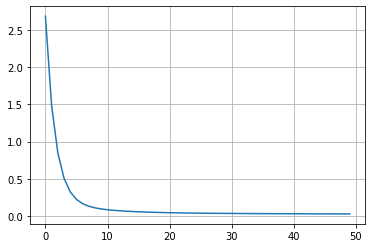

In [10]:
plt.plot(losses)
plt.grid(True, which='both')
plt.show()

Теперь соберем предсказания модели для каждой последовательности из D дискрет и заодно посчитаем отклонения от истинных значений

In [11]:
X_PRED = X[:D]
errors = []

for i in range(0, len(upcoming_points)):
    x_test = torch.FloatTensor(np.array(sequences[i]))
    upcoming_point_pred = predict(adaline, x_test)
    X_PRED += upcoming_point_pred.numpy().tolist()
    errors += (upcoming_point_pred - upcoming_points[i]).numpy().tolist()

И для сравнения посмотрим на исходную и предсказанную временные последовательности

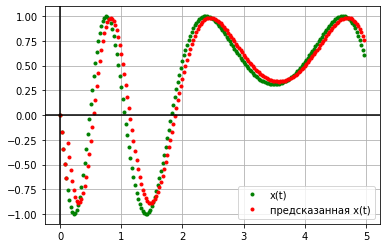

In [12]:
plt.plot(t, X, '.', color="green", label='x(t)')
plt.plot(t, X_PRED, '.', color="red", label='предсказанная x(t)')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

И визуализируем наши отклонения

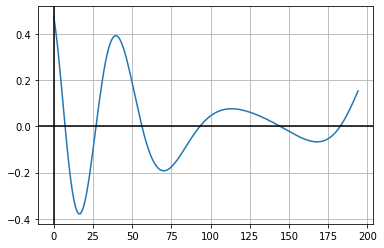

In [13]:
plt.plot(errors)

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()

Определим входные данные для задачи подавления помех

In [14]:
D = 4  # число дискрет


def true_signal(t):
    return np.sin(t**2 - 6 * t + 3)


def noized_signal(t):
    return (1 / 4) * np.sin(t**2 - 6 * t - 2 * np.pi)


t = np.arange(0, 5, 0.025)      # отрезок с шагом
X = true_signal(t).tolist()     # истинный сигнал
Y = noized_signal(t).tolist()   # зашумленный сигнал


noized_sequences = [Y[i:i+D] for i in range(0, len(Y) - D)] # последовательности из D дискрет (зашумленный сигнал)  
upcoming_points_true = [X[i] for i in range(D, len(X))]     # последующие дискреты (истинный сигнал)

assert len(noized_sequences) == len(upcoming_points_true)

In [15]:
x_train, y_train = sync_shuffle(np.array(noized_sequences), np.array(upcoming_points_true))

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

Наша вторая нейросеть будет принимать на вход `D` зашумленных дискрет и иметь один выходной нейрон, последущую очищенную дискрету

In [16]:
adaline2 = ADALINE(D, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(adaline2.parameters(), lr=0.05)

Обучим модель

In [ ]:
losses2 = fit(adaline2, x_train, y_train, loss_function, optimizer, 600)

Посмотрим на график функции потерь, вычисляющей `MSE` между исходными и полученными данными

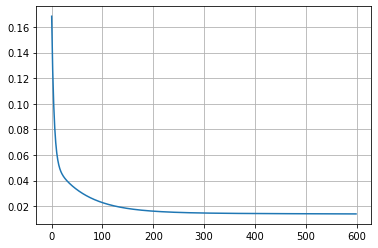

In [18]:
plt.plot(losses2)
plt.grid(True, which='both')
plt.show()

Теперь соберем предсказания модели для каждой последовательности из D дискрет и заодно посчитаем отклонения от истинных значений

In [19]:
x_test = torch.FloatTensor(np.array(noized_sequences))
upcoming_points_pred = predict(adaline2, x_test).numpy().flatten().tolist()

X_PRED = X[:D] + upcoming_points_pred

errors2 = [pred - true for pred, true in zip(upcoming_points_pred, upcoming_points_true)]

И теперь посмотрим в сравнении на истинный, зашумленный и очищенный сигналы

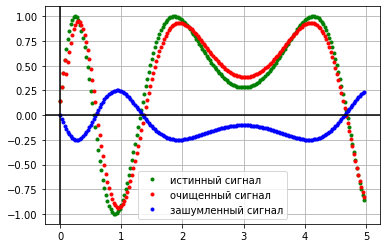

In [20]:
plt.plot(t, X, '.', color="green", label='истинный сигнал')
plt.plot(t, X_PRED, '.', color="red", label='очищенный сигнал')
plt.plot(t, Y, '.', color="blue", label='зашумленный сигнал')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

И визуализируем наши отклонения

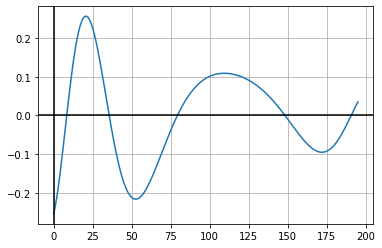

In [21]:
plt.plot(errors2)

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()

`Выводы:` в ходе данной работы была построена линейная нейросетевая модель, которая была применена для двух задач:
- аппроксимация функции
- подавление помех в сигнале

И после обучения (50 и 600 эпох соответственно) были получены хорошие результаты